In [53]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [54]:
df = pd.read_csv(r"E:\Laptop Data\Amit Panchal\Internship Projects\Shopper Spectrum\online_retail.csv")

In [55]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2022 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2022 8:26,3.39,17850.0,United Kingdom


In [56]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [58]:
df.shape

(541909, 8)

In [59]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

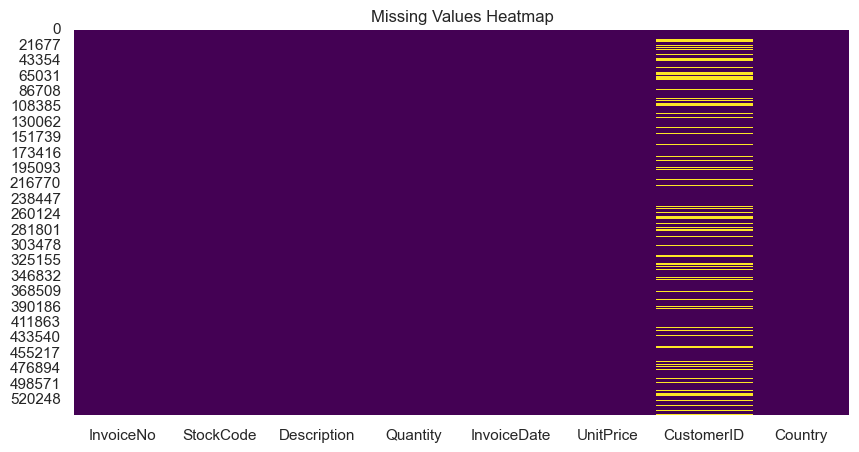

In [60]:
# Visualize Missing Values
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


In [61]:
# Unique counts for each column
for col in df.columns:
    print(f"{col} → {df[col].nunique()} unique values")


InvoiceNo → 25900 unique values
StockCode → 4070 unique values
Description → 4223 unique values
Quantity → 722 unique values
InvoiceDate → 23260 unique values
UnitPrice → 1630 unique values
CustomerID → 4372 unique values
Country → 38 unique values


# Data Cleaning

In [62]:
# Drop missing CustomerID and Description
df = df[df['CustomerID'].notnull()]
df = df[df['Description'].notnull()]

print("After dropping nulls:", df.shape)


After dropping nulls: (406829, 8)


In [63]:
# Remove returns (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

print("After removing returns:", df.shape)


After removing returns: (397924, 8)


In [64]:
# Keep only positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

print("After removing negative or zero Quantity/UnitPrice:", df.shape)


After removing negative or zero Quantity/UnitPrice: (397884, 8)


In [65]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Optional: clean description
df['Description'] = df['Description'].str.strip().str.lower()

print("Data types after conversion:\n", df.dtypes)


Data types after conversion:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object


In [66]:
df.shape

(397884, 8)

In [67]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [68]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [69]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2022-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# Customer Segmentation

calculated RFM (Recency, Frequency, Monetary) features per customer:

In [70]:
# Set reference date for recency (usually max + 1 day)
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# View sample
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


RFM Scores

In [71]:
# Recency: lower is better, so invert score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency: higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Monetary: higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Combine to single RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']].head())


   CustomerID  Recency  Frequency  Monetary RFM_Score
0       12346      326          1  77183.60       115
1       12347        2          7   4310.00       555
2       12348       75          4   1797.24       244
3       12349       19          1   1757.55       414
4       12350      310          1    334.40       112


Segment Customers based on RFM Score

In [72]:
# Total RFM Score
rfm['RFM_Total'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Simple segmentation function
def segment_customer(row):
    if row['RFM_Total'] >= 12:
        return 'Loyal'
    elif row['R_Score'] >= 4:
        return 'Recent'
    elif row['F_Score'] >= 4:
        return 'Frequent'
    elif row['M_Score'] >= 4:
        return 'Big Spender'
    else:
        return 'At Risk'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# View final RFM with segments
print(rfm[['CustomerID', 'RFM_Score', 'RFM_Total', 'Segment']].head())


   CustomerID RFM_Score  RFM_Total      Segment
0       12346       115          7  Big Spender
1       12347       555         15        Loyal
2       12348       244         10     Frequent
3       12349       414          9       Recent
4       12350       112          4      At Risk


Visualize Segment Counts

C:\Users\amitp\AppData\Local\Temp\ipykernel_53048\3681123396.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')


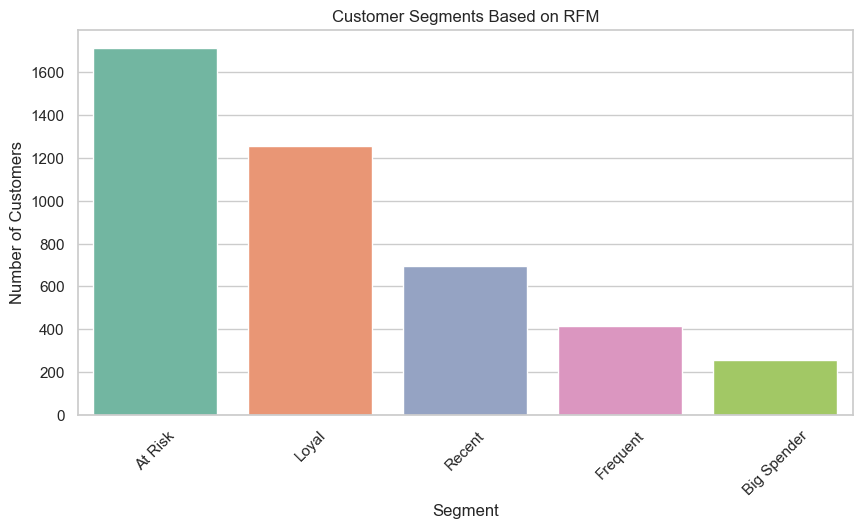

In [73]:
plt.figure(figsize=(10,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.title("Customer Segments Based on RFM")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


RFM Distribution Plots

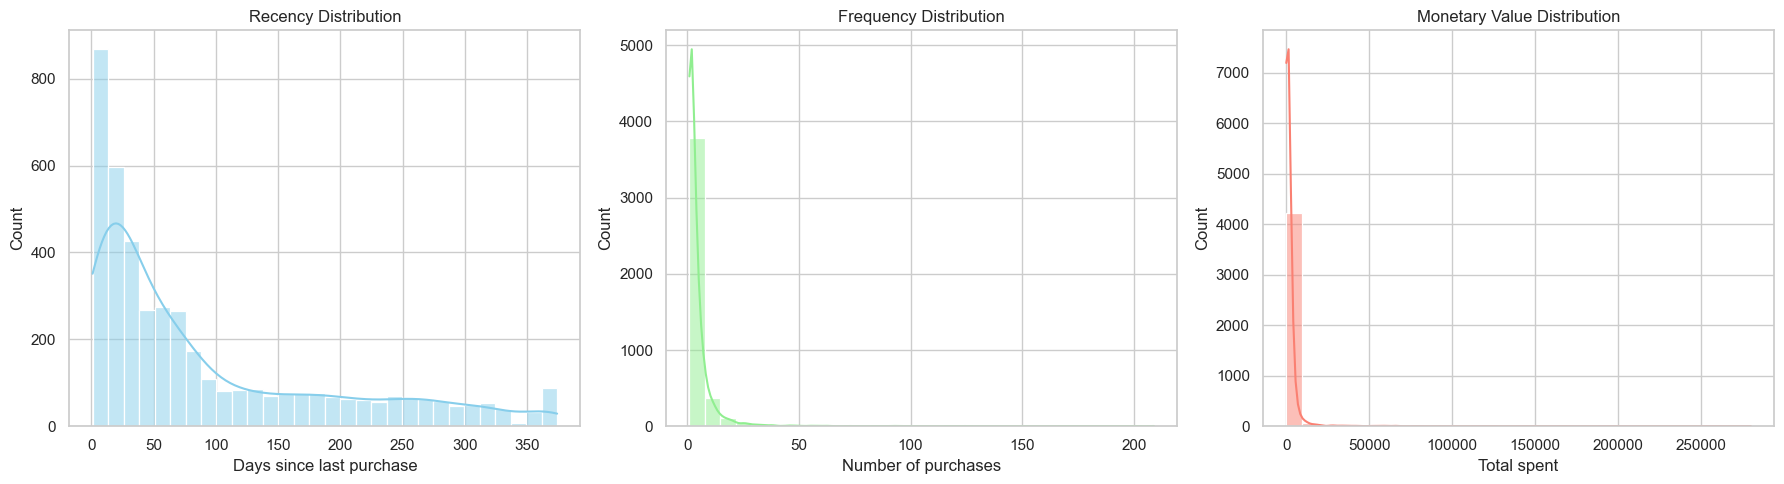

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(18, 5))

# Recency Distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')

# Frequency Distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of purchases')

# Monetary Distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True, color='salmon')
plt.title('Monetary Value Distribution')
plt.xlabel('Total spent')

plt.tight_layout()
plt.show()


RFM Score Heatmap (Customer Count in Score Buckets)

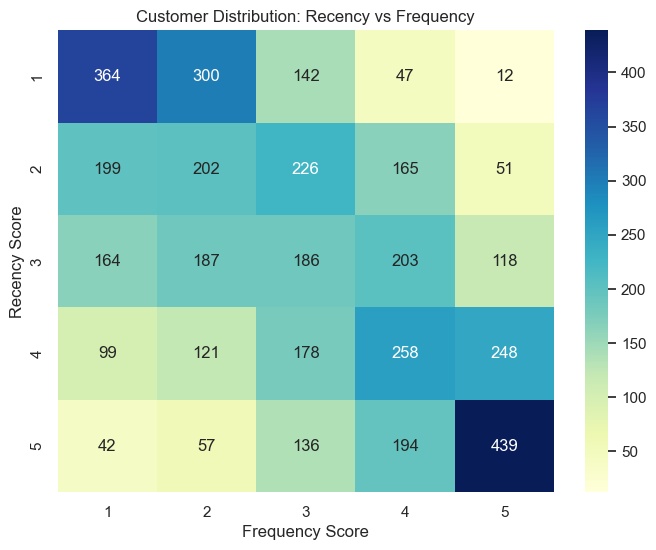

In [75]:
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='CustomerID', aggfunc='count')

plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Customer Distribution: Recency vs Frequency')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()


 Boxplot of Monetary by Segment

C:\Users\amitp\AppData\Local\Temp\ipykernel_53048\2741003681.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='Segment', y='Monetary', palette='pastel')


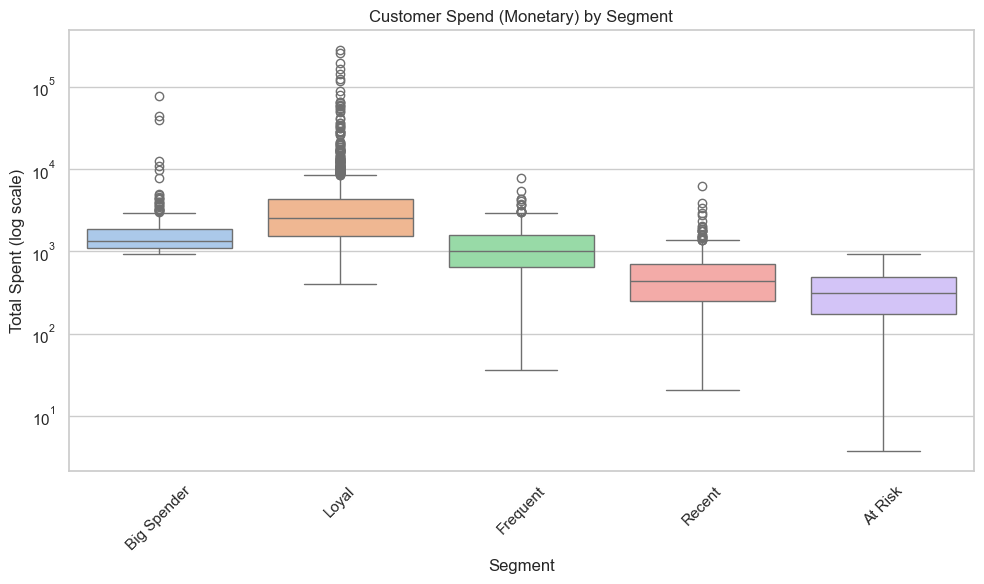

In [76]:
plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Monetary', palette='pastel')
plt.yscale('log')  # Log scale to handle extreme outliers
plt.title("Customer Spend (Monetary) by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Spent (log scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Country-wise Customer Analysis

C:\Users\amitp\AppData\Local\Temp\ipykernel_53048\509376908.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x='Country', y='CustomerID', palette='coolwarm')


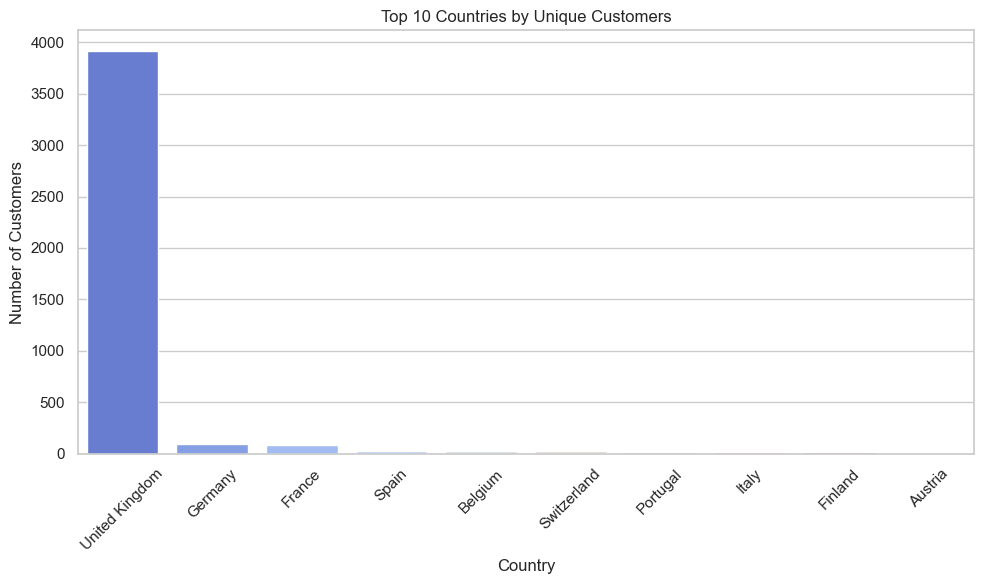

In [77]:
# Top countries by number of customers
top_countries = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=top_countries, x='Country', y='CustomerID', palette='coolwarm')
plt.title("Top 10 Countries by Unique Customers")
plt.ylabel("Number of Customers")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [78]:
from datetime import datetime

In [79]:
# 2. 📦 Top-Selling Products (By Quantity & Revenue)
# -----------------------------------------------
top_products_qty = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
top_products_rev = df.groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(10)

In [80]:
top_products_qty


Description
paper craft , little birdie           80995
medium ceramic top storage jar        77916
world war 2 gliders asstd designs     54415
jumbo bag red retrospot               46181
white hanging heart t-light holder    36725
assorted colour bird ornament         35362
pack of 72 retrospot cake cases       33693
popcorn holder                        30931
rabbit night light                    27202
mini paint set vintage                26076
Name: Quantity, dtype: int64

Top Selling Products

C:\Users\amitp\AppData\Local\Temp\ipykernel_53048\1022454741.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products_qty.index, x=top_products_qty.values, palette="coolwarm")


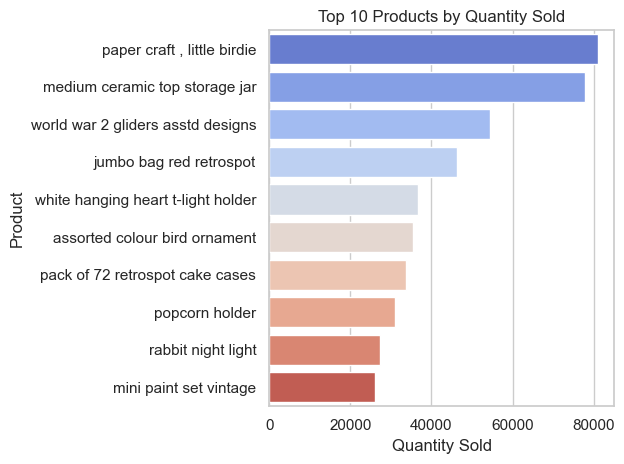

In [81]:
# By Quantity ---- By quantity sold and revenue earned.
plt.figure()
sns.barplot(y=top_products_qty.index, x=top_products_qty.values, palette="coolwarm")
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Quantity Sold")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

By Revenue

C:\Users\amitp\AppData\Local\Temp\ipykernel_53048\3716136759.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products_rev.index, x=top_products_rev.values, palette="magma")


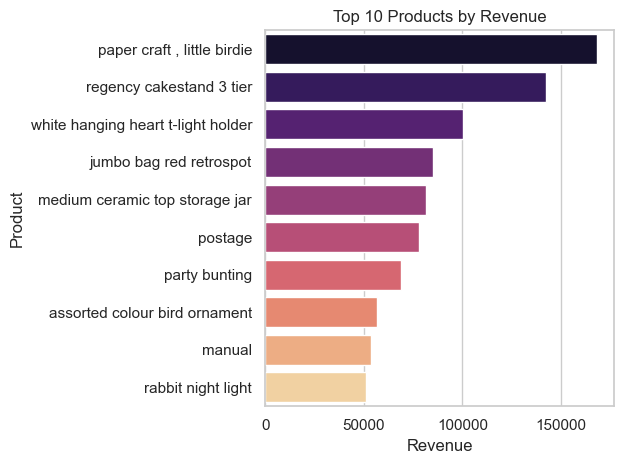

In [82]:
plt.figure()
sns.barplot(y=top_products_rev.index, x=top_products_rev.values, palette="magma")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

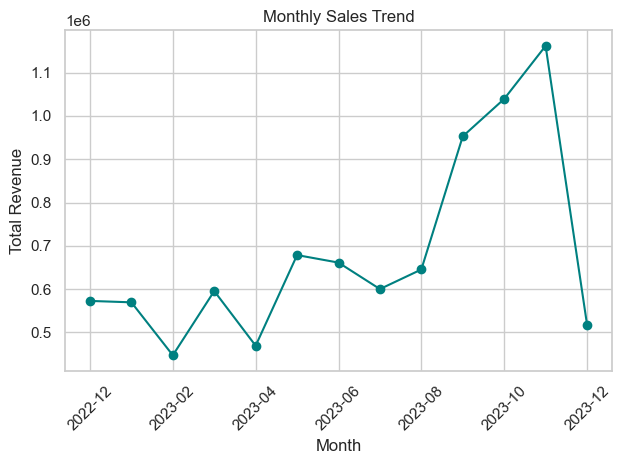

In [83]:
# 3. 📆 Sales Trends Over Time ----- Monthly revenue trend to observe seasonality.

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)
monthly_sales = df.groupby("InvoiceMonth")["TotalPrice"].sum()

plt.figure()
monthly_sales.plot(kind='line', marker='o', color='teal')
plt.title("Monthly Sales Trend")
plt.ylabel("Total Revenue")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# 5.RFM Analysis - Customer Behavior
# Snapshot date: latest invoice + 1 day
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [85]:
snapshot_date

Timestamp('2023-12-10 12:50:00')

 Normalize/Standardize the RFM features

In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


 Elbow Method & Silhouette Score to Determine K

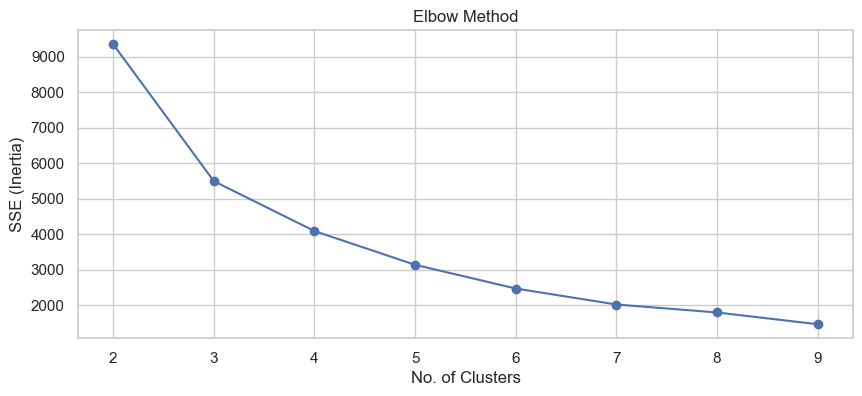

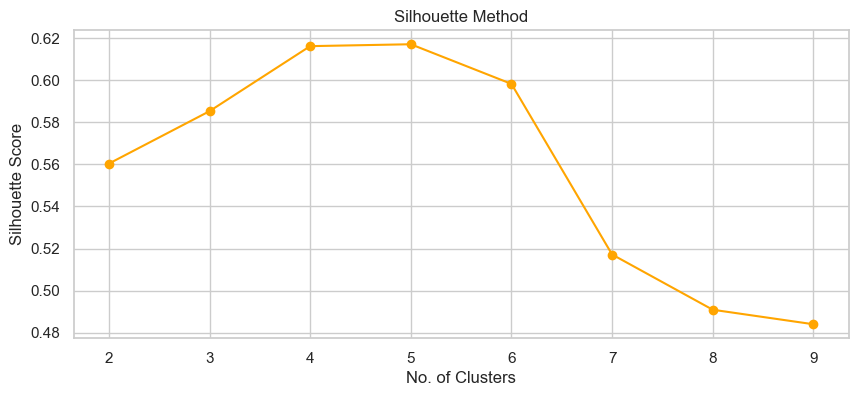

In [87]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

sse = []
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Elbow Plot
plt.figure(figsize=(10,4))
plt.plot(range(2, 10), sse, marker='o')
plt.xlabel("No. of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

# Silhouette Score Plot
plt.figure(figsize=(10,4))
plt.plot(range(2, 10), silhouette_scores, marker='o', color='orange')
plt.xlabel("No. of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.grid(True)
plt.show()


 Apply KMeans Clustering

In [88]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,3
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,0
3,12349,19,1,1757.55,0
4,12350,310,1,334.40,1


Label Clusters with Business Logic
We'll label each cluster (e.g., "High-Value", "Occasional", etc.) based on mean RFM values per cluster:

In [89]:
rfm.groupby('Cluster').mean().sort_values('Monetary', ascending=False)


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
2,15435.000000,7.384615,82.538462,127338.313846
3,15212.857843,15.500000,22.333333,12709.090490
0,15289.128356,43.702685,3.682711,1359.049284
1,15347.791940,248.075914,1.552015,480.617480


In [90]:
#Use conditions to assign readable names:
def label_cluster(row):
    if row['Cluster'] == 0:
        return 'High-Value'
    elif row['Cluster'] == 1:
        return 'Regular'
    elif row['Cluster'] == 2:
        return 'At-Risk'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(label_cluster, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346,326,1,77183.60,3,Occasional
1,12347,2,7,4310.00,0,High-Value
2,12348,75,4,1797.24,0,High-Value
3,12349,19,1,1757.55,0,High-Value
4,12350,310,1,334.40,1,Regular


Visualize the Clusters

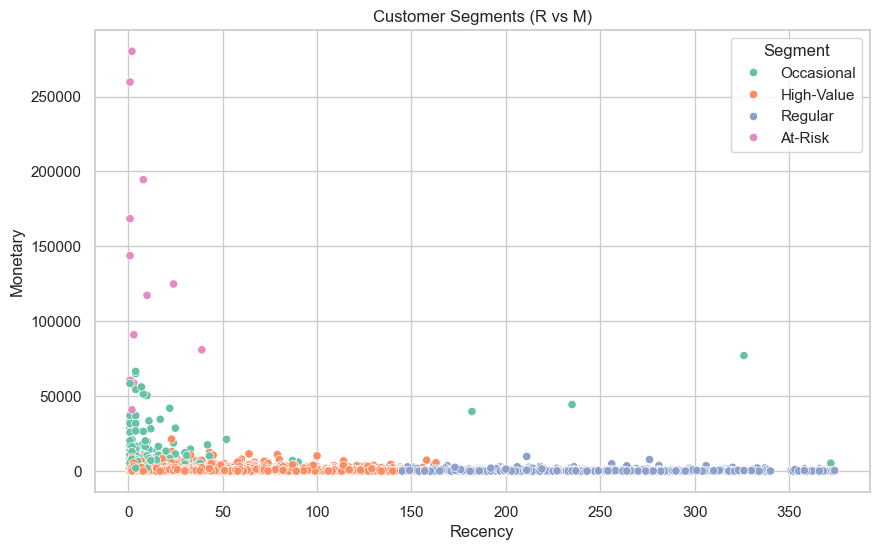

In [91]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set2')
plt.title("Customer Segments (R vs M)")
plt.show()


In [109]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth
0,536365,85123A,white hanging heart t-light holder,6,2022-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2022-12
1,536365,71053,white metal lantern,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2022-12


In [110]:
# model_training.py

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Ensure model directory exists
os.makedirs("model", exist_ok=True)

# RFM Feature Engineering
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (pd.Timestamp('2021-01-01') - pd.to_datetime(x).max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# Save the scaler and model
with open("model/rfm_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("model/rfm_kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

print("✅ RFM scaler and KMeans model saved successfully!")


✅ RFM scaler and KMeans model saved successfully!


In [92]:
import os

# Create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [105]:
import joblib

# Save scaler and model
joblib.dump(scaler, 'models/rfm_scaler.pkl')



['models/rfm_scaler.pkl']

In [104]:
joblib.dump(kmeans, 'models/rfm_kmeans_model.pkl')

['models/rfm_kmeans_model.pkl']

In [111]:
import pickle

with open("model/rfm_kmeans_model.pkl", "rb") as f:
    model = pickle.load(f)

print("Model loaded successfully")


Model loaded successfully


# Recommendation System

Build User-Item Matrix

In [94]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'df' is your cleaned dataframe
df_rec = df.dropna(subset=['CustomerID'])
df_rec['CustomerID'] = df_rec['CustomerID'].astype(str)

# Create user-item matrix (Quantity of products purchased by each customer)
user_item_matrix = df_rec.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum'
).fillna(0)


Build Cosine Similarity Model

In [95]:
# Compute cosine similarity between customers
similarity_matrix = cosine_similarity(user_item_matrix)

# Create DataFrame for easy lookups
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)


Recommend Products for a Customer

In [96]:
def recommend_products(customer_id, top_n=5):
    if customer_id not in similarity_df.index:
        return "Customer ID not found."

    # Get most similar customer
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).drop(customer_id).index

    recommended_items = pd.Series(dtype='float64')

    for similar_customer in similar_customers:
        # Items purchased by similar customer
        items = user_item_matrix.loc[similar_customer]
        # Filter out items already purchased by the target customer
        items = items[user_item_matrix.loc[customer_id] == 0]
        # Add to recommendation pool
        recommended_items = recommended_items.add(items, fill_value=0)
        if len(recommended_items) >= top_n:
            break

    recommended_items = recommended_items.sort_values(ascending=False).head(top_n)
    return recommended_items


In [97]:
recommend_products('17850')


StockCode
22170    4.0
71038    2.0
22171    1.0
40003    1.0
22168    1.0
dtype: float64

In [98]:
stockcode_desc = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')
recommendations = recommend_products('17850')

for code in recommendations.index:
    print(f"{stockcode_desc.loc[code, 'Description']} - Score: {recommendations[code]:.2f}")


picture frame wood triple portrait - Score: 4.00
white hanging beads candle holder - Score: 2.00
3 hook photo shelf antique white - Score: 1.00
white bamboo ribs lampshade - Score: 1.00
organiser wood antique white - Score: 1.00


In [99]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

detailed_output = df[df['StockCode'].isin(recommendations.index)][['StockCode', 'Description', "Country", "Quantity", "TotalPrice", "InvoiceDate"]].drop_duplicates(subset="StockCode")


In [100]:
detailed_output['Score'] = detailed_output['StockCode'].map(recommendations)

In [101]:
# Display result
for _, row in detailed_output.iterrows():
    print(f"Product: {row['Description']}")
    print(f"  - Score: {row['Score']:.2f}")
    print(f"  - Country: {row['Country']}")
    print(f"  - Quantity: {row['Quantity']}")
    print(f"  - TotalPrice: {row['TotalPrice']:.2f}")
    print(f"  - InvoiceDate: {row['InvoiceDate']}")
    print("-----------")

Product: organiser wood antique white
  - Score: 1.00
  - Country: United Kingdom
  - Quantity: 2
  - TotalPrice: 17.00
  - InvoiceDate: 2022-12-01 09:56:00
-----------
Product: 3 hook photo shelf antique white
  - Score: 1.00
  - Country: United Kingdom
  - Quantity: 2
  - TotalPrice: 17.00
  - InvoiceDate: 2022-12-01 14:03:00
-----------
Product: picture frame wood triple portrait
  - Score: 4.00
  - Country: United Kingdom
  - Quantity: 3
  - TotalPrice: 20.25
  - InvoiceDate: 2022-12-02 11:21:00
-----------
Product: white hanging beads candle holder
  - Score: 2.00
  - Country: United Kingdom
  - Quantity: 2
  - TotalPrice: 10.90
  - InvoiceDate: 2022-12-08 12:17:00
-----------
Product: white bamboo ribs lampshade
  - Score: 1.00
  - Country: United Kingdom
  - Quantity: 1
  - TotalPrice: 1.25
  - InvoiceDate: 2022-12-09 13:08:00
-----------


In [112]:
joblib.dump(scaler, 'svd_recommender.pkl')

['svd_recommender.pkl']

In [103]:
df.to_csv("cleaned_sales_data.csv", index=False)
